# Financial Compliance LLM Evaluation Pipeline

This notebook implements an automated MLOps pipeline for evaluating and optimizing Large Language Model (LLM) prompts for financial compliance tasks using Amazon SageMaker Pipelines.

## Overview

The pipeline automates the complete lifecycle of prompt engineering and model evaluation, from optimization through deployment, with integrated experiment tracking and quality gates.

## Architecture Components

1. MLflow Integration: Centralized logging of parameters, metrics, and artifacts
2. Bedrock Prompt Management: Prompt Versioning,  Automated Optimization
3. Modular Pipeline Steps

## Pipeline Steps

### Step 1: Data Preparation  
- Retrieves base prompt from Bedrock Prompt Management, optimizes
- Logs optimization metrics and improved prompts
- Loads ground truth dataset from S3, preprocesses
- Validates data format and completeness

### Step 2: Model Inference
- Executes Haystack pipeline with optimized prompts
- Generates predictions on test dataset

### Step 3: Evaluation & Metrics
- Calculates accuracy, precision, recall, F1-score
- Generates confusion matrix analysis
- Logs comprehensive evaluation metrics

### Key Features

#### Automated Quality Control
- Configurable accuracy thresholds
- Comprehensive evaluation metrics

#### Scalable Infrastructure
- SageMaker remote functions for distributed processing
- Configurable compute resources

#### Production-Ready Monitoring
- MLflow experiment tracking for full audit trails
- Integration with AWS IAM and security best practices

#### Configuration Parameters

- `ModelId`: Bedrock model identifier (default: amazon.nova-lite-v1:0)
- `PromptId`: Bedrock Prompt Management ID for base template
- `Optimize`: Enable/disable DSPy prompt optimization
- `AccuracyThreshold`: Minimum accuracy for deployment (default: 0.8)
- `RateLimitDelay`: API throttling delay in seconds


### Environment Setup
This cell installs required Python packages and initializes the environment used throughout the notebook. It ensures that all dependencies such as Torch, Diffusers, Haystack, or AWS SDKs are available.

In [ ]:
#Install requirements
!pip install -r requirements.txt --quiet

^C


In [3]:
from haystack.core.pipeline import Pipeline
#from haystack import Pipeline
from haystack.components.converters import PyPDFToDocument
from haystack.components.writers import DocumentWriter
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack_integrations.document_stores.chroma import ChromaDocumentStore
from haystack_integrations.components.retrievers.chroma import ChromaQueryTextRetriever
from pandas import DataFrame
import json

## Setup Chroma DB vector store


Chroma is a lightweight, open-source vector database designed for storing and retrieving document embeddings. In this workflow, we use Chroma to persist embeddings generated from the 10-K PDF and perform semantic search over the document using vector similarity, enabling question-answering and context retrieval. If no embedding model is specified "all-MiniLM-L6-v2" (which produces 384-dimensional embeddings) as the default embedding model.

### ChromaDB Metadata Field Explanations

- **split_id** — The index of this text chunk within the full set of splits generated from the document.
- **file_path** — The name of the original source file from which this chunk was extracted.
- **source_id** — A unique hash/identifier representing the original document, used to group or deduplicate content.
- **page_number** — The PDF page number where this chunk originates.
- **split_idx_start** — The character offset in the full extracted text indicating where this chunk begins.


In [4]:
#File source
file_names = ['../data/AMZN-2023-10k.pdf']

#Folder where vector DB will exist 
document_store = ChromaDocumentStore(persist_path='../data/10k-vec-db')

# Uncomment to recreate the vec store
# pipeline = Pipeline()
# pipeline.add_component("converter", PyPDFToDocument())
# pipeline.add_component("cleaner", DocumentCleaner())
# pipeline.add_component("splitter", DocumentSplitter(split_by="word", split_length=150))
# pipeline.add_component("writer", DocumentWriter(document_store=document_store))
# pipeline.connect("converter", "cleaner")
# pipeline.connect("cleaner", "splitter")
# pipeline.connect("splitter", "writer")

# pipeline.run({"converter": {"sources": file_names}})

#Setup Chroma retriever
retriever = ChromaQueryTextRetriever(document_store=document_store)

#query with top k 
results = retriever.run(query="Who is Amazon's Senior Vice President and General Counsel?", top_k=2)

#Output parser
docs = results["documents"]

def doc_to_json(doc):
    return {
        "content": doc.content,
        "meta": doc.meta,
        "score": doc.score
    }

pretty = json.dumps([doc_to_json(d) for d in docs], indent=2)
print(pretty)

C:\Users\mtahsin\.cache\chroma\onnx_models\all-MiniLM-L6-v2\onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:04<00:00, 17.0MiB/s]


[
  {
    "content": "T. Olsavsky. Mr. Olsavsky has served as Senior Vice President and Chief Financial Officer since June 2015, Vice President, Finance for the\nGlobal Consumer Business from December 2011 to June 2015, and numerous financial leadership roles across Amazon with global responsibility since April\n2002.\nShelley L. Reynolds. Ms. Reynolds has served as Vice President, Worldwide Controller, and Principal Accounting Officer since April 2007.\nAdam N. Selipsky. Mr. Selipsky has served as CEO Amazon Web Services since July 2021, Senior Vice President, Amazon Web Services from May\n2021 until July 2021, President and CEO of Tableau Software from September 2016 until May 2021, and Vice President, Marketing, Sales and Support of\nAmazon Web Services from May 2005 to September 2016.\nDavid A. Zapolsky. Mr. Zapolsky has served as Senior Vice President, General Counsel, and Secretary since May 2014, Vice President, General\nCounsel, and Secretary from September 2012 to May 2014, an

## Agent Setup with RAG + Web Search Tools

This cell defines an Agent where a Bedrock-hosted LLM decides **when to use retrieval vs. live web search**, based on the time period of the question.

**Key Components:**
- **AmazonBedrockChatGenerator**: The LLM backend (Qwen 32B) generating responses and deciding which tool to call.
- **`@tool` Decorators**: Wrap Python functions so the agent can call them dynamically during reasoning.
- **Chroma-based RAG Retriever (`rag_tool`)**: Returns grounded text chunks from the **Amazon 10-K (up to 2023)**.
- **DuckDuckGo Search (`web_search`)**: Provides **current, real-time** info for 2024+ queries.

**Behavioral Logic Enforced in `system_prompt`:**
- **Use RAG** for questions asking about **2023 or earlier**.
- **Use Web Search** for **2024 or later** or “current” questions.
- **Exactly one tool call per question** — **never both**.
- **No extra reasoning shown** — final outputs are clean, factual answers.

In [5]:
from haystack.components.agents import Agent
from haystack.dataclasses import ChatMessage
from haystack_integrations.components.generators.amazon_bedrock import AmazonBedrockChatGenerator
from haystack.tools import tool
from ddgs.exceptions import DDGSException, RatelimitException
from ddgs import DDGS

@tool
def web_search(keywords: str, region: str = "us-en", max_results: int = 3) -> str:
    """Search the web for updated information.
    
    Args:
        keywords (str): The search query keywords.
        region (str): The search region: wt-wt, us-en, uk-en, ru-ru, etc..
        max_results (int | None): The maximum number of results to return.
    Returns:
        List of dictionaries with search results.
    
    """
    try:
        results = DDGS().text(keywords, region=region, max_results=max_results)
        return results if results else "No results found."
    except RatelimitException:
        return "Rate limit reached. Please try again later."
    except DDGSException as e:
        return f"Search error: {e}"
    except Exception as e:
        return f"Search error: {str(e)}"

@tool
def rag_tool(query: str) -> str:
    """Use this tool to get grounded information for answering users queries about 2023 and earlier"""
    docs = retriever.run(query=query)['documents']
    return [doc.content for doc in docs]

agent = Agent(
    chat_generator=AmazonBedrockChatGenerator(model="qwen.qwen3-32b-v1:0", generation_kwargs={"temperature":0.1}),
    tools=[web_search, rag_tool],
    system_prompt="""
        You are a professional Amazon research agent with access to two tools:
        1. Context retrieval tool: Contains Amazon 10-K filings data through 2023
        2. Web search tool: For current information beyond 2023

        TOOL SELECTION RULES:
        - Use ONLY the context retrieval tool for questions about Amazon data from 2023 or earlier
        - Use ONLY the web search tool for questions about Amazon data from 2024 or later
        - NEVER use both tools for a single query
        - You must call the single tool you selected based on the criteria ONCE AND ONLY ONCE

        EXAMPLES FOR CONTEXT RETRIEVAL TOOL (2023 and earlier data):
        - "What was Amazon's revenue in 2022?" → Use context_retrieval_tool
        - "Who was Amazon's CFO in 2023?" → Use context_retrieval_tool
        - "What were Amazon's operating expenses in 2021?" → Use context_retrieval_tool
        - "Who served on Amazon's board of directors in 2023?" → Use context_retrieval_tool

        EXAMPLES FOR WEB SEARCH TOOL (2024 and later data):
        - "What is Amazon's current stock price?" → Use web_search
        - "What are Amazon's 2024 earnings?" → Use web_search
        - "Who is Amazon's current CEO?" → Use web_search
        - "What new products did Amazon launch in 2024?" → Use web_search

        DECISION LOGIC:
        - If the question asks about historical data (2023 or earlier) → context_retrieval_tool
        - If the question asks about current/recent data (2024 or later) → web_search
        - If the question doesn't specify a time period but asks for "current" information → web_search

        Give concise, factual answers without preamble. Always use exactly one tool per response.
        """,
    exit_conditions=["text"], # <-- stops when agent starts to produce normal conversation text 
    max_agent_steps=2, # <-- one tool call + one final answer 
    raise_on_tool_invocation_failure=False
)

In [6]:
agent.warm_up() #<-- performs a lightweight, dry-run initialization so that all this setup happens before the user asks their first real question.

### Web Search Tool Example

- A **ChatPromptBuilder** is used to generate a structured prompt containing strict instructions.
- The system enforces:
  - One and only one tool call  
  - Tool selection based on year-specific logic  
    - Questions about **2023 or earlier** → `context_retrieval_tool`  
    - Questions about **2024 or current data** → `web_search`
- The formatted prompt is sent to the agent, which executes the single tool call.
- The response is printed using a helper function to visualize the messages and tool usage.


In [7]:
from chat_message_printer import print_chat_messages
from haystack.components.builders.chat_prompt_builder import ChatPromptBuilder

#Setup prompt template
def format_prompt(query):
    template = [ChatMessage.from_user(
        "Using only ONE of the available tools, accurately answer the following question:\n\n{{question}}\n\n" +
        "CRITICAL INSTRUCTIONS:\n" +
        "- Select EXACTLY ONE tool based on the time period criteria in your system prompt\n" +
        "- Make ONLY ONE tool call - do not break down or modify the query\n" +
        "- If the question is about 2023 or earlier Amazon data → use context_retrieval_tool\n" +
        "- If the question is about 2024+ or current Amazon data → use web_search\n" +
        "- Answer directly after your single tool call"
    )]
    builder = ChatPromptBuilder(template=template, required_variables=['question'])
    result = builder.run(question=query)
    return result['prompt']
#Add query to template
prompt = format_prompt("Who is Amazon's current CEO?")

#Send query to agent
response = agent.run(prompt)

#Output parser
print_chat_messages(response)

Agent reached maximum agent steps of 2, stopping.


=== CHAT CONVERSATION ===

[1] SYSTEM
📝 Text: 
        You are a professional Amazon research agent with access to two tools:
        1. Context retrieval tool: Contains Amazon 10-K filings data through 2023
        2. Web search tool: For current information beyond 2023

        TOOL SELECTION RULES:
        - Use ONLY the context retrieval tool for questions about Amazon data from 2023 or earlier
        - Use ONLY the web search tool for questions about Amazon data from 2024 or later
        - NEVER use both tools for a single query
        - You must call the single tool you selected based on the criteria ONCE AND ONLY ONCE

        EXAMPLES FOR CONTEXT RETRIEVAL TOOL (2023 and earlier data):
        - "What was Amazon's revenue in 2022?" → Use context_retrieval_tool
        - "Who was Amazon's CFO in 2023?" → Use context_retrieval_tool
        - "What were Amazon's operating expenses in 2021?" → Use context_retrieval_tool
        - "Who served on Amazon's board of directors in 202

## RAG tool example

In [ ]:
#Add query to template
#prompt = format_prompt("Who was Amazon's Senior Vice President and General Counsel in 2023?")
#Send query to agent
#response = agent.run(prompt)
#output parser
#print_chat_messages(response)

### Ground Truth Dataset Overview

This dataset represents a collection of question–answer pairs used to evaluate the performance of the agent. Each row contains both the **query** and the **expected answer**, along with metadata describing how the ground-truth label was sourced.

**Columns Explained**

- **prompt** — The natural-language question that will be passed to the agent.  
  This is the input the agent must answer using either RAG or web search.

- **context** — (Optional) The extracted text from the source document used to derive the ground-truth answer.  
  - Present for **RAG-labeled** rows.  
  - `None` for web-search questions.

- **output** — The ground-truth answer.  
  This is the gold-standard response that the agent’s answer will be compared against.

- **page** — (For RAG rows) The page number in the Amazon 10-K document where the supporting information was found.

- **tool_label** — Indicates which tool should ideally be used to answer the question:  
  - **`rag`** → Question relates to *historical Amazon data* found in the PDF.  
  - **`web_search`** → Question relates to *current or modern information* requiring external web search.

---

### How We Use This Data for Evaluation

For each row:

1. We take the **prompt** and send it to the agent.  
2. The agent selects a tool (`rag` or `web_search`) following system rules.  
3. The agent returns an answer.  
4. We compare the agent’s answer with the **output** column (ground truth).  
5. For RAG rows, we can also check if the retrieved chunks match the **context** column.  
6. Metrics such as accuracy, similarity scores, or nDCG are computed to determine how close the agent’s answer is to the ground truth.

This process allows us to measure:
- Tool-selection correctness  
- Factual correctness  
- Retrieval quality for RAG-based questions  
- Overall agent reliability across mixed data sources  


In [8]:
import pandas as pd

df = pd.read_json('../data/ground_truth.json', orient='records')
df.head(20)

,prompt,context,output,page,tool_label
0,Who is Amazon's Senior Vice President and Gene...,None,David A. Zapolsky is the Senior Vice President...,NaN,web_search
1,Where are Amazon's international headquarters ...,None,Amazon owns and leases corporate headquarters ...,NaN,web_search
2,How much outstanding borrowings is under Amazo...,None,$6.8 billion of borrowings outstanding under t...,NaN,web_search
3,What is the name of Amazon's satellite broadba...,None,Amazon's satellite broadband internet project ...,NaN,web_search
4,What was the total cash paid for income taxes ...,"[billion as of December 31, 2021 and 2022. Our...",The total cash paid for income taxes is $6.035...,42.0,rag
5,What is the total square footage of office spa...,None,Total office space leased in north america is ...,NaN,web_search
6,What are Amazon's four business principles?,None,Amazon is guided by four principles: customer ...,NaN,web_search
7,What is the total cash balance in the year 2022?,[activities was $46.3 billion and $46.8 billio...,"Per the balance sheet, cash balance ending 202...",39.0,rag
8,What is Amazon's operating income in 2021,"[1,263 Total operating expenses 363,165 444,94...","Amazon's operating income in 2021 is $24,879 m...",24.0,rag
9,How much was AWS sales growth in 2022?,"[$ 315,880 International 127,787 118,007 AWS 6...","AWS sales increased 29% in 2022, compared to t...",24.0,rag


## Generate answers 
- takes approximately ~5 minutes

In [9]:
from tqdm import tqdm
import time

answers = []
for prompt in tqdm(df.prompt.to_list()):
    print(prompt)
    prompt = format_prompt(prompt)
    answers.append(agent.run(prompt))
    time.sleep(10)

  0%|          | 0/20 [00:00<?, ?it/s]

Who is Amazon's Senior Vice President and General Counsel?


Agent reached maximum agent steps of 2, stopping.
  5%|▌         | 1/20 [00:11<03:40, 11.63s/it]

Where are Amazon's international headquarters located?


Agent reached maximum agent steps of 2, stopping.
 10%|█         | 2/20 [00:23<03:31, 11.77s/it]

How much outstanding borrowings is under Amazon's commercial paper program?


Agent reached maximum agent steps of 2, stopping.
 15%|█▌        | 3/20 [00:35<03:19, 11.75s/it]

What is the name of Amazon's satellite broadband internet project?


Agent reached maximum agent steps of 2, stopping.
 20%|██        | 4/20 [00:47<03:08, 11.79s/it]

What was the total cash paid for income taxes in 2022


Agent reached maximum agent steps of 2, stopping.
 25%|██▌       | 5/20 [01:00<03:04, 12.31s/it]

What is the total square footage of office space leased in north america?


Agent reached maximum agent steps of 2, stopping.
 30%|███       | 6/20 [01:13<02:54, 12.47s/it]

What are Amazon's four business principles?


Agent reached maximum agent steps of 2, stopping.
 35%|███▌      | 7/20 [01:25<02:40, 12.38s/it]

What is the total cash balance in the year 2022?


Agent reached maximum agent steps of 2, stopping.
 40%|████      | 8/20 [01:37<02:27, 12.30s/it]

What is Amazon's operating income in 2021


Agent reached maximum agent steps of 2, stopping.
 45%|████▌     | 9/20 [01:50<02:17, 12.49s/it]

How much was AWS sales growth in 2022?


Agent reached maximum agent steps of 2, stopping.
 50%|█████     | 10/20 [02:04<02:11, 13.14s/it]

What is the international business operating income in 2021?


Agent reached maximum agent steps of 2, stopping.
 55%|█████▌    | 11/20 [02:18<01:59, 13.23s/it]

What were the company's key areas of investment?


Agent reached maximum agent steps of 2, stopping.
 60%|██████    | 12/20 [02:34<01:52, 14.04s/it]

On what stock exchange are Amazon's common shares traded?


Agent reached maximum agent steps of 2, stopping.
 65%|██████▌   | 13/20 [02:47<01:36, 13.78s/it]

What shipping challenges does Amazon face?


Agent reached maximum agent steps of 2, stopping.
 70%|███████   | 14/20 [03:00<01:21, 13.55s/it]

What external events could negatively impact Amazon's shipping abilities?


Agent reached maximum agent steps of 2, stopping.
 75%|███████▌  | 15/20 [03:12<01:05, 13.18s/it]

What is making it hard for Amazon to hire and deploy workers in its fulfillment centers?


Agent reached maximum agent steps of 2, stopping.
 80%|████████  | 16/20 [03:24<00:51, 12.75s/it]

Where in the financial statements is the foreign exchange rate effect information provided?


Agent reached maximum agent steps of 2, stopping.
 85%|████████▌ | 17/20 [03:36<00:37, 12.63s/it]

What did Amazon do with their common stock on May 27, 2022?


Agent reached maximum agent steps of 2, stopping.
 90%|█████████ | 18/20 [03:49<00:24, 12.48s/it]

What are the three primary customer sets Amazon serves?


Agent reached maximum agent steps of 2, stopping.
 95%|█████████▌| 19/20 [04:01<00:12, 12.50s/it]

What was the amount of cash paid for income taxes, net of refunds, in 2020?


Agent reached maximum agent steps of 2, stopping.
100%|██████████| 20/20 [04:13<00:00, 12.66s/it]


### Clean and Normalize Agent Answers

This cell processes the raw agent responses and prepares them for evaluation:

- **`raw_answers`** stores the full response object returned by the agent, including message history and tool calls.
- **`clean_answers`** extracts only the final text answer from each response.  
  - If the final message is missing or empty, it defaults to `"I don't know"` to avoid null values during evaluation.

These cleaned answers will later be compared against the ground-truth outputs to measure answer correctness and overall agent performance.

In [10]:
#Clean data frame 
df['raw_answers'] = answers
df['clean_answers'] = [answer['messages'][-1].text if answer['messages'][-1].text is not None else "I don't know" for answer in answers]
# uncomment below if you would like to print
#df['clean_answers'].to_list()

### Extract Retrieved Documents from Agent Tool Calls

This cell builds a robust parser that extracts the **retrieved context documents** returned by the agent’s `context_retrieval_tool`. Since tool responses may vary in structure (JSON strings, Python literals, dicts, lists, or custom objects), the helper functions standardize and normalize them into a clean list of `haystack.Document` objects.

**Key Components:**

- **`_parse_result_payload`**  
  Safely converts the raw tool payload into a Python object.  
  - Tries JSON parsing  
  - Falls back to `ast.literal_eval`  
  - Defaults to wrapping the string as a single document

- **`_coerce_to_documents`**  
  Converts any parsed object—dicts, lists, nested structures—into a list of `Document` objects, ensuring consistent formatting of:
  - `content` (text)  
  - `meta` / metadata fields  

- **`get_clean_docs(answer)`**  
  Walks through all tool messages in the agent’s response and:
  - Identifies messages originating from `context_retrieval_tool`
  - Extracts the attached result payload
  - Parses and normalizes it into a structured list of documents

Finally, we populate a new dataframe column:

- **`extracted_contexts`** — the cleaned list of retrieved documents per query.

In [11]:
# Create full dataframe
import json
import ast
from haystack import Document

def _parse_result_payload(payload):
    """Return a Python object from payload (str|list|dict)."""
    if isinstance(payload, (list, dict)):
        return payload
    if isinstance(payload, str):
        s = payload.strip()
        # try JSON first
        try:
            return json.loads(s)
        except Exception:
            pass
        # then ast as a fallback
        try:
            return ast.literal_eval(s)
        except Exception:
            # last resort: treat the raw string as a single doc
            return [{"content": s}]
    # Unknown type -> wrap as string
    return [{"content": str(payload)}]

def _coerce_to_documents(obj):
    """Normalize various shapes to List[haystack.Document]."""
    # If it's a dict, look for common keys
    if isinstance(obj, dict):
        for key in ("documents", "docs", "results", "retrieved_documents", "retrieved_docs"):
            if key in obj and isinstance(obj[key], list):
                return _coerce_to_documents(obj[key])
        # maybe it’s a single doc-like dict
        obj = [obj]

    # Now expect a list of doc-like items
    docs_out = []
    if isinstance(obj, list):
        for item in obj:
            if isinstance(item, Document):
                docs_out.append(item)
                continue
            if isinstance(item, dict):
                content = (
                    item.get("content")
                    or item.get("text")
                    or item.get("page_content")
                    or ""
                )
                meta = item.get("meta") or item.get("metadata") or {}
                if content is None:
                    content = ""
                docs_out.append(Document(content=content, meta=meta))
                continue
            # anything else -> coerce to string content
            docs_out.append(Document(content=str(item), meta={}))
    return docs_out

def get_clean_docs(answer, target_tool_name="context_retrieval_tool"):
    """
    Walks tool messages in `answer['messages']` and extracts documents robustly.
    """
    try:
        # 1) collect candidate payloads from TOOL messages
        candidates = []
        for msg in answer.get("messages", []):
            # Handle role checks defensively
            role = getattr(msg, "_role", None)
            role_val = getattr(role, "value", None) or getattr(msg, "role", None)
            if str(role_val).lower() != "tool":
                continue

            content = getattr(msg, "_content", None) or getattr(msg, "content", None) or []
            # content may be a list; scan for objects with .result
            if isinstance(content, list):
                for part in content:
                    result = getattr(part, "result", None)
                    origin = getattr(part, "origin", None)
                    tool_name = getattr(origin, "tool_name", None)
                    if result is None:
                        continue
                    if target_tool_name and tool_name == target_tool_name:
                        candidates.append(result)
                    else:
                        # keep a fallback candidate in case no named tool matches
                        candidates.append(result)

        if not candidates:
            return []

        # 2) prefer first payload from the target tool if found, else first payload
        payload = None
        for c in candidates:
            # pick the first one whose origin matched in the loop above
            payload = c
            break

        # 3) parse payload -> python object
        parsed = _parse_result_payload(payload)

        # 4) normalize to haystack.Document list
        return _coerce_to_documents(parsed)

    except Exception as e:
        print(f"Error parsing documents: {e}")
        return []

# usage:
df['extracted_contexts'] = [get_clean_docs(answer) for answer in answers]

In [12]:
#Uncomment for extra information about the dataframe created
#df.keys()
#df.iloc[0].raw_answers

In [13]:
df.head(20)

,prompt,context,output,page,tool_label,raw_answers,clean_answers,extracted_contexts
0,Who is Amazon's Senior Vice President and Gene...,None,David A. Zapolsky is the Senior Vice President...,NaN,web_search,{'messages': [ChatMessage(_role=<ChatRole.SYST...,The search results did not provide the specifi...,[Document(id=d4675c57fcfe114db0b95f1da46eea3c5...
1,Where are Amazon's international headquarters ...,None,Amazon owns and leases corporate headquarters ...,NaN,web_search,{'messages': [ChatMessage(_role=<ChatRole.SYST...,Amazon's international headquarters are locate...,[Document(id=d4675c57fcfe114db0b95f1da46eea3c5...
2,How much outstanding borrowings is under Amazo...,None,$6.8 billion of borrowings outstanding under t...,NaN,web_search,{'messages': [ChatMessage(_role=<ChatRole.SYST...,"As of December 31, 2022, there were $6.8 billi...",[Document(id=205bf78a7fc44bd5712c1f021b0dd8841...
3,What is the name of Amazon's satellite broadba...,None,Amazon's satellite broadband internet project ...,NaN,web_search,{'messages': [ChatMessage(_role=<ChatRole.SYST...,The name of Amazon's satellite broadband inter...,[Document(id=da7b2733fcd5afb01618730afe278b08c...
4,What was the total cash paid for income taxes ...,"[billion as of December 31, 2021 and 2022. Our...",The total cash paid for income taxes is $6.035...,42.0,rag,{'messages': [ChatMessage(_role=<ChatRole.SYST...,The total cash paid for income taxes in 2022 w...,[Document(id=dfed806e6a31234905fe244edb214f03d...
5,What is the total square footage of office spa...,None,Total office space leased in north america is ...,NaN,web_search,{'messages': [ChatMessage(_role=<ChatRole.SYST...,The total square footage of office space lease...,[Document(id=ce95f95acbdd8003b6c401701ca670e7e...
6,What are Amazon's four business principles?,None,Amazon is guided by four principles: customer ...,NaN,web_search,{'messages': [ChatMessage(_role=<ChatRole.SYST...,Amazon's four business principles are:\n\n1. *...,[Document(id=73d745b332b991ce016e513d295a297d6...
7,What is the total cash balance in the year 2022?,[activities was $46.3 billion and $46.8 billio...,"Per the balance sheet, cash balance ending 202...",39.0,rag,{'messages': [ChatMessage(_role=<ChatRole.SYST...,The total cash balance for the year 2022 was $...,[Document(id=318d7ef975a998617926dc3877666990f...
8,What is Amazon's operating income in 2021,"[1,263 Total operating expenses 363,165 444,94...","Amazon's operating income in 2021 is $24,879 m...",24.0,rag,{'messages': [ChatMessage(_role=<ChatRole.SYST...,"Amazon's operating income in 2021 was $24,879 ...",[Document(id=7fa51590235a839415a57bb0d5d090fe6...
9,How much was AWS sales growth in 2022?,"[$ 315,880 International 127,787 118,007 AWS 6...","AWS sales increased 29% in 2022, compared to t...",24.0,rag,{'messages': [ChatMessage(_role=<ChatRole.SYST...,AWS sales grew by 29% in 2022 compared to the ...,[Document(id=bc3f59fa598d9937f34eb4838adc520a0...


### Evaluating Answer Quality with Semantic Similarity

To assess how well our retrieval-augmented generation (RAG) system answers questions, we need a metric that goes beyond exact keyword matching. Different answers may use different wording but still convey the same meaning — especially with LLMs.

**Semantic Answer Similarity (SAS)** provides a **meaning-based evaluation** by embedding both the predicted answer and the ground-truth answer, and then measuring how similar those embeddings are. Higher scores indicate the answers are semantically closer.

In the next cell, we use Haystack’s `SASEvaluator` to compute:
- **Individual similarity scores** for each question
- **An average score** that summarizes overall model performance

We should be able to see that Qwen does decently when it comes to semantic similarity 

In [14]:
from haystack.components.evaluators import SASEvaluator
import pandas as pd

gt = df["output"].to_list()
pa = df["clean_answers"].to_list()

sas_evaluator = SASEvaluator()
sas_evaluator.warm_up()
result = sas_evaluator.run(
    ground_truth_answers=gt,
    predicted_answers=pa
)

# Attach scores to the dataframe
df["sas_score"] = result["individual_scores"]

# Build a compact view with truncated text
def truncate(text, n=80):
    text = str(text)
    return text if len(text) <= n else text[:n] + "..."

eval_view = df[["prompt", "output", "clean_answers", "sas_score"]].copy()
eval_view["prompt"] = eval_view["prompt"].apply(lambda x: truncate(x, 60))
eval_view["output"] = eval_view["output"].apply(lambda x: truncate(x, 80))
eval_view["clean_answers"] = eval_view["clean_answers"].apply(lambda x: truncate(x, 80))
eval_view["sas_score"] = eval_view["sas_score"].round(3)

display(eval_view)

print(f"\nAverage SAS score: {result['score']:.3f}")

c:\Users\mtahsin\Documents\reInvent-2025\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mtahsin\Documents\reInvent-2025\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mtahsin\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or 

,prompt,output,clean_answers,sas_score
0,Who is Amazon's Senior Vice President and Gene...,David A. Zapolsky is the Senior Vice President...,The search results did not provide the specifi...,0.407
1,Where are Amazon's international headquarters ...,Amazon owns and leases corporate headquarters ...,Amazon's international headquarters are locate...,0.829
2,How much outstanding borrowings is under Amazo...,$6.8 billion of borrowings outstanding under t...,"As of December 31, 2022, there were $6.8 billi...",0.847
3,What is the name of Amazon's satellite broadba...,Amazon's satellite broadband internet project ...,The name of Amazon's satellite broadband inter...,0.944
4,What was the total cash paid for income taxes ...,The total cash paid for income taxes is $6.035...,The total cash paid for income taxes in 2022 w...,0.641
5,What is the total square footage of office spa...,Total office space leased in north america is ...,The total square footage of office space lease...,0.954
6,What are Amazon's four business principles?,Amazon is guided by four principles: customer ...,Amazon's four business principles are:\n\n1. *...,0.927
7,What is the total cash balance in the year 2022?,"Per the balance sheet, cash balance ending 202...",The total cash balance for the year 2022 was $...,0.842
8,What is Amazon's operating income in 2021,"Amazon's operating income in 2021 is $24,879 m...","Amazon's operating income in 2021 was $24,879 ...",0.987
9,How much was AWS sales growth in 2022?,"AWS sales increased 29% in 2022, compared to t...",AWS sales grew by 29% in 2022 compared to the ...,0.912



Average SAS score: 0.772


### Extract and Analyze Tools Used per Agent Interaction

This cell inspects the raw agent response to identify **which tools were invoked** during each question–answer interaction. Because a response may contain multiple tool messages, we:

- Walk through all messages in the agent’s response.
- Check for entries containing a `tool_name` attribute.
- Normalize tool names:
  - Any variant of `context_retrieval_*` → `rag`
  - Any variant of `web_search_*` → `web_search`
- Collect the unique tools used in a single interaction and join them with a `|` separator.

The resulting column **`tool_used`** provides an easy way to audit whether the agent:
- Selected the correct tool for the question,
- Used multiple tools when it should have used only one,
- Or made no tool calls at all.

We will be able to see based on the results the Qwen does well in selecting Websearch when it should be a Websearch call, but often uses Websearch when it should be a RAG call. Theese are the nuances that should be considered when selecting a final model for your usecase.

Tool usage patterns (normalized):
tool_used
rag           14
web_search     6
Name: count, dtype: int64


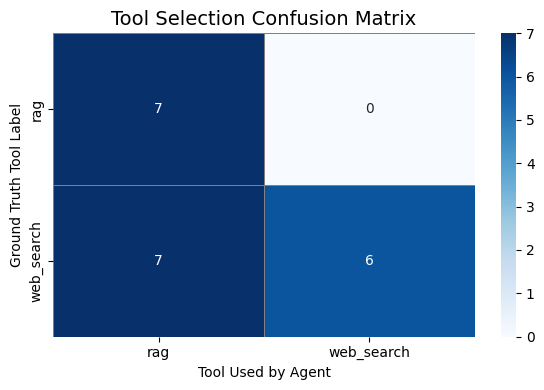

Tool Selection Accuracy: 65.00%


In [16]:
def extract_combined_tools(raw_answer):
    """Extract all tools used in one interaction and join with |"""
    tools_used = []
    
    if not raw_answer or 'messages' not in raw_answer:
        return 'none'
    
    messages = raw_answer.get('messages', [])
    
    for message in messages:
        content = getattr(message, '_content', []) or []
        
        for item in content:
            if hasattr(item, 'tool_name'):
                tool_name = item.tool_name

                # Normalize tool names
                if 'context_retrieval' in tool_name or 'rag_tool' in tool_name:
                    tool_name = 'rag'
                elif 'web_search' in tool_name:
                    tool_name = 'web_search'
                
                if tool_name not in tools_used:
                    tools_used.append(tool_name)
    
    return ' | '.join(tools_used) if tools_used else 'none'

df['tool_used'] = df['raw_answers'].apply(extract_combined_tools)

print("Tool usage patterns (normalized):")
print(df['tool_used'].value_counts())

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Confusion matrix: ground truth vs actual tool used
tool_confusion = pd.crosstab(df['tool_label'], df['tool_used'])

# 2. Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    tool_confusion,
    annot=True,            # show cell values
    fmt='d',               # integer formatting
    cmap='Blues',          # heatmap color scheme
    linewidths=.5,
    linecolor='gray',
    cbar=True
)
plt.title("Tool Selection Confusion Matrix", fontsize=14)
plt.xlabel("Tool Used by Agent")
plt.ylabel("Ground Truth Tool Label")
plt.tight_layout()
plt.show()

# 3. Accuracy calculation
correct = sum(
    tool_confusion.loc[tool, tool] 
    for tool in tool_confusion.index 
    if tool in tool_confusion.columns
)
total = tool_confusion.to_numpy().sum()
accuracy = correct / total

print(f"Tool Selection Accuracy: {accuracy:.2%}")


### LLM-as-a-Judge Evaluation (Factual Accuracy Check)

This cell uses a **large language model as an evaluator** to determine whether the model’s generated answer is **factually correct** given the retrieved context. Instead of comparing answers by exact wording, we use the LLM to judge whether the statements are **supported by evidence** in the context.

**What happens in this cell:**
- We build an input payload (`content`) containing:
  - The **question asked**
  - The **model’s generated answer**
  - The **retrieved context** (if available)
- We provide the evaluator with **few-shot examples** showing how to score statements as:
  - **1** → factually correct and supported
  - **0** → incorrect or unsupported
- We configure `LLMEvaluator` to call a **Bedrock-hosted Llama 3 model** in *judge mode*, with strict instructions to return a **JSON score only**, ensuring consistency and evaluability.
- The evaluator then returns a **numerical score** indicating whether the model’s answer aligns with the evidence.

**Why this matters:**
This approach allows us to evaluate **grounded correctness**, not just similarity. It confirms whether the model is:
- Using retrieved context properly
- Avoiding hallucination
- Making claims that are supported by the data

We should be able to see that Qwen does around 50% in the factual accuracy check 

In [17]:
import time
import json
import logging
from typing import List, Any, Dict

import numpy as np
import pandas as pd

from haystack.components.evaluators import LLMEvaluator
from haystack_integrations.components.generators.amazon_bedrock import AmazonBedrockChatGenerator

# ------------------------------------------------------------------
# Silence noisy logs (PromptBuilder warnings, etc.)
# ------------------------------------------------------------------
logging.getLogger("haystack").setLevel(logging.ERROR)

# ------------------------------------------------------------------
# Few-shot examples for LLM-as-a-judge
# ------------------------------------------------------------------
examples = [
    {
        "inputs": {
            "questions": "What was Amazon's revenue growth in Q2 2024?",
            "contexts": """Amazon reported Q2 2024 net sales of $147.98 billion, representing a 10% increase compared to Q2 2023. North America segment sales were $90.03 billion (9% growth) and International segment sales were $31.66 billion (7% growth). AWS revenue reached $26.28 billion, up 19% year-over-year."""
        },
        "outputs": {
            "statements": [
                "Amazon's Q2 2024 net sales were $147.98 billion, up 10% from the previous year.",
                "The strong performance was driven primarily by Prime Day sales in June."
            ],
            "statement_scores": [1, 0]  # [accurate data, unsupported claim about Prime Day]
        }
    },
    {
        "inputs": {
            "questions": "Who is Amazon's current Chief Executive Officer?",
            "contexts": """Andy Jassy serves as President and Chief Executive Officer of Amazon. He succeeded Jeff Bezos in July 2021. Prior to becoming CEO, Jassy founded and led Amazon Web Services (AWS) from its inception in 2006, serving as CEO of AWS until his promotion to company CEO."""
        },
        "outputs": {
            "statements": [
                "Andy Jassy is Amazon's CEO, having succeeded Jeff Bezos in July 2021.",
                "Before becoming CEO, he founded and led AWS since 2006 until his promotion."
            ],
            "statement_scores": [1, 1]  # [accurate, accurate]
        }
    },
    {
        "inputs": {
            "questions": "What are Amazon's main advertising revenue sources?",
            "contexts": """Amazon's advertising services generated $12.77 billion in Q1 2024, primarily from sponsored products, sponsored brands, and display advertising. The majority comes from sellers promoting their products on Amazon's marketplace, with additional revenue from brands advertising across Amazon's properties and third-party sites."""
        },
        "outputs": {
            "statements": [
                "Amazon's advertising revenue in Q1 2024 was $12.77 billion from sponsored products and display ads.",
                "This represents a 24% increase from the same quarter in the previous year."
            ],
            "statement_scores": [1, 0]  # [accurate, unsupported percentage claim]
        }
    }
]

# ------------------------------------------------------------------
# Configure Bedrock chat generator
# ------------------------------------------------------------------
bedrock_generator = AmazonBedrockChatGenerator(
    model="us.meta.llama3-3-70b-instruct-v1:0",
    generation_kwargs={
        "temperature": 0
    }
)

# ------------------------------------------------------------------
# Create LLM-as-a-judge evaluator (progress bar disabled)
# ------------------------------------------------------------------
llm_evaluator = LLMEvaluator(
    instructions="""Evaluate if the answer is factually correct given the context.
    Return ONLY a valid JSON object with a score of:
    - 1 for correct answers that match the context
    - 0 for incorrect or unsupported answers
    Response must be valid JSON with format: {"score": number}""",
    chat_generator=bedrock_generator,
    inputs=[("predicted_answers", List[str])],
    outputs=["score"],
    examples=examples,
    raise_on_failure=True,
    progress_bar=False,  # <- disable tqdm bar
)

# ------------------------------------------------------------------
# Build evaluation payload for ALL rows in df
# ------------------------------------------------------------------
eval_items: list[Dict[str, Any]] = []

for _, row in df.iterrows():
    question = row["prompt"]
    answer = row["clean_answers"]
    ctx = row.get("context", None)

    item: Dict[str, Any] = {
        "inputs": {
            "questions": question,
        },
        "outputs": {
            "statements": [answer],
        },
    }

    # Attach context if available (handles None / NaN safely)
    if ctx is not None and not (isinstance(ctx, float) and np.isnan(ctx)):
        item["inputs"]["contexts"] = ctx

    eval_items.append(item)

print(f"Running LLM-as-a-judge factuality evaluation on {len(eval_items)} items...\n")

# ------------------------------------------------------------------
# Run evaluator per item with 10s delay (no spammy prints)
# ------------------------------------------------------------------
scores: list[Any] = []
metas: list[Any] = []

for i, item in enumerate(eval_items):
    try:
        results = llm_evaluator.run(predicted_answers=[item])
        judge_result = results["results"][0]
        judge_meta = results["meta"][0]

        scores.append(judge_result.get("score", None))
        metas.append(judge_meta)
    except Exception as e:
        # Keep alignment even if something fails
        scores.append(None)
        metas.append(None)
        print(f"Warning: error on item {i+1}: {e}")

    if i < len(eval_items) - 1:
        time.sleep(10)

print("LLM-as-a-judge evaluation complete.\n")

# ------------------------------------------------------------------
# Attach scores back to df & pretty summary
# ------------------------------------------------------------------
df["llm_judge_score"] = scores

valid_scores = [s for s in scores if s is not None]
if valid_scores:
    avg_score = float(np.mean(valid_scores))
    ones = sum(1 for s in valid_scores if s == 1)
    zeros = sum(1 for s in valid_scores if s == 0)

    # Try to pull model name from first successful meta
    first_meta = next((m for m in metas if m is not None), {})
    model_name = first_meta.get("model", "unknown")
    usage = first_meta.get("usage", {})

    summary = {
        "llm_judge_model": model_name,
        "average_factuality_score": avg_score,
        "num_items_evaluated": len(valid_scores),
        "num_supported_answers_(score=1)": ones,
        "num_unsupported_answers_(score=0)": zeros,
        "example_token_usage": usage,
    }

    print("LLM-as-a-Judge Evaluation Summary:")
    print(json.dumps(summary, indent=2))

    # Score distribution print
    print("\nScore distribution:")
    print(pd.Series(valid_scores).value_counts().sort_index())
else:
    print("No valid scores returned from LLM evaluator.")

# ------------------------------------------------------------------
# Neat table of low-scoring answers
# ------------------------------------------------------------------
print("\nSample low-scoring answers (score = 0):")
low_scoring = df[df["llm_judge_score"] == 0][
    ["prompt", "clean_answers", "llm_judge_score"]
].head(5)

# Make long text wrap nicely in the notebook
styled_low = (
    low_scoring.style
    .set_properties(
        subset=["prompt", "clean_answers"],
        **{"white-space": "pre-wrap"}
    )
)

display(styled_low)

Running LLM-as-a-judge factuality evaluation on 20 items...

LLM-as-a-judge evaluation complete.

LLM-as-a-Judge Evaluation Summary:
{
  "llm_judge_model": "us.meta.llama3-3-70b-instruct-v1:0",
  "average_factuality_score": 0.5,
  "num_items_evaluated": 20,
  "num_supported_answers_(score=1)": 10,
  "num_unsupported_answers_(score=0)": 10,
  "example_token_usage": {
    "prompt_tokens": 606,
    "completion_tokens": 7,
    "total_tokens": 613
  }
}

Score distribution:
0    10
1    10
Name: count, dtype: int64

Sample low-scoring answers (score = 0):


,prompt,clean_answers,llm_judge_score
0,Who is Amazon's Senior Vice President and General Counsel?,The search results did not provide the specific information about Amazon's Senior Vice President and General Counsel.,0
1,Where are Amazon's international headquarters located?,"Amazon's international headquarters are located in Seattle, Washington, USA.",0
2,How much outstanding borrowings is under Amazon's commercial paper program?,"As of December 31, 2022, there were $6.8 billion of borrowings outstanding under Amazon's Commercial Paper Programs.",0
4,What was the total cash paid for income taxes in 2022,"The total cash paid for income taxes in 2022 was $2,175 million (U.S. Federal: Current) based on the information provided.",0
5,What is the total square footage of office space leased in north america?,"The total square footage of office space leased in North America, as of December 31, 2022, is 30,611 thousand (or 30.611 million) square feet.",0


### Evaluating RAG Context Quality with nDCG

In retrieval-augmented generation (RAG), it is important not only that the system retrieves *relevant* documents, but also that it ranks the **most relevant** documents **higher** in the results.  
To measure this, we use **Normalized Discounted Cumulative Gain (nDCG)**, a ranking-based evaluation metric.

**What this cell does:**
- Selects only the rows where the agent was expected to use **RAG retrieval** (`tool_label == "rag"`).
- Extracts:
  - The **ground-truth context** that should have been retrieved.
  - The **actual retrieved context** from the RAG system.
- Converts the ground-truth contexts into **Haystack `Document` objects**, grouped per query.
- Uses `DocumentNDCGEvaluator` to compute how well the retrieved documents are ordered by relevance.

**How to interpret the score:**
- `1.0` → The retrieved documents are in the **ideal order** (perfect ranking).
- `0.0` → The retrieved ranking is **completely wrong**.
- Values between 0 and 1 show **how close** the retrieval ordering is to optimal.

This metric tells us **how well the RAG retriever prioritizes the most relevant chunks**, which directly affects the **accuracy and grounding quality** of generated answers.

This metric is also isolated from direct LLM performance. 


In [18]:
from haystack import Document
from haystack.components.evaluators import DocumentNDCGEvaluator
import numpy as np
import pandas as pd

# --- 1. Filter to RAG rows only ---
rag_df = df[df["tool_label"] == "rag"].copy()

# --- 2. Build ground-truth documents as List[List[Document]] ---
context_gt = []
for ctx in rag_df["context"].to_list():
    if isinstance(ctx, list):
        context_gt.append([Document(content=str(doc)) for doc in ctx])
    else:
        # Fallback: empty list if context is missing or malformed
        context_gt.append([])

# Retrieved documents already stored as List[List[Document]]
retrieved_docs = rag_df["extracted_contexts"].to_list()

# --- 3. Run nDCG evaluator ---
evaluator = DocumentNDCGEvaluator()
result = evaluator.run(
    ground_truth_documents=context_gt,
    retrieved_documents=retrieved_docs,
)

individual_scores = result["individual_scores"]
avg_score = result["score"]

# --- 4. Attach scores back to the RAG dataframe ---
rag_df = rag_df.reset_index(drop=False).rename(columns={"index": "row_index"})
rag_df["ndcg_score"] = [round(s, 3) for s in individual_scores]

# --- 5. Pretty summary printout ---
print("RAG Retrieval Quality (nDCG)")
print(f"- Number of RAG rows: {len(rag_df)}")
print(f"- Average nDCG: {avg_score:.3f}")
print(f"- Min nDCG: {min(individual_scores):.3f}")
print(f"- Max nDCG: {max(individual_scores):.3f}")
print("\nPer-row nDCG scores:", [round(s, 3) for s in individual_scores])

# --- 6. Show a neat table of the lowest-scoring queries ---
print("\nLowest nDCG queries (worst retrieval cases):")
worst = (
    rag_df.sort_values("ndcg_score")
          .loc[:, ["prompt", "ndcg_score"]]
          .head(5)
)

styled = (
    worst.style
    .set_properties(
        subset=["prompt"],
        **{"white-space": "pre-wrap"}
    )
)

display(styled)

RAG Retrieval Quality (nDCG)
- Number of RAG rows: 7
- Average nDCG: 0.439
- Min nDCG: 0.151
- Max nDCG: 0.645

Per-row nDCG scores: [0.494, 0.151, 0.619, 0.645, 0.403, 0.447, 0.316]

Lowest nDCG queries (worst retrieval cases):


,prompt,ndcg_score
1,What is the total cash balance in the year 2022?,0.151000
6,"What was the amount of cash paid for income taxes, net of refunds, in 2020?",0.316000
4,What is the international business operating income in 2021?,0.403000
5,"What did Amazon do with their common stock on May 27, 2022?",0.447000
0,What was the total cash paid for income taxes in 2022,0.494000


## Notebook End 

This is the end of the piece by piece evaluation. Next go under the "sm_mlflow_pipe" folder and open the "sm_pipe.ipynb" notebook to productionalize what happened here with Sagemaker Pipelines & MLFlow!